# Analyzing 60 Years of Billboard Top Singles
15-388 Final Project <br>
Aditi Chattopadhyay, Sandhya Bala, Minji Lee

# Table of Contents

<ol>
    <li>Motivation</li>
    <li>Data Collection</li>
    <li>Preliminary Analysis</li>
    <ul>
        <li>Genre Analysis</li>
        <li>Song Length Analysis</li>
        <li>Number of Unique Songs</li>
        <li>Sentiment Analysis</li>
    </ul>
    <li>Analysis Based on Gender</li>
    <ul>
        <li>Number of Female Artists</li>
        <li>Sentiment Analysis</li>
        <li>Word Cloud</li>
    </ul>
    <li>Predicting Gender</li>
    <li>Summary and Future Works</li>
    <li>References</li>
</ol>


# Motivation
Music is an integral part of culture and society. Just last week, Spotify revealed that I spent roughly 64,000 minutes listening to music in 2019 - that is 41 days! Historically, music has been able to reflect social changes and important historical moments by engaging society with its short and catchy tunes. For example, Sam Cooke’s “A Change is Going to Come” in the 60s was written as a protest song to support civil rights.  Songs from “You Don’t Own Me” by Lesley Gore to Beyonce’s “Run The World” tracks the different waves of the feminist movement. So, as one would expect, songs have a lot of hidden trends and data to unpack. We wanted to investigate songs even further. 


**Installing the Libraries**: Before we can proceed with the data analysis, we need to install the following libraries:

In [1]:
import requests
import json
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import re
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import csv
import collections
!pip install wordcloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.metrics import mean_squared_error 
!pip install wikipedia
import wikipedia
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/minjilee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Collection
Wikipedia had a page that showed a list of weekly Billboard Top Single for each year. We scraped each page using the requests library and used BeautifulSoup to create a dictionary of songs where the key is year and the values are list of tuples storing the title and the artist of each songs. 

In [2]:
def hotSingles(year):
    res = []
    
    url = "https://en.wikipedia.org/wiki/List_of_Billboard_Hot_100_number-one_singles_of_"
    req = requests.get(url+str(year)).text
    soup = BeautifulSoup(req)
    table = soup.find_all("table", {'class':"wikitable"}).pop()
    rows = table.findAll("tr")
    numCol = len(rows[0].findAll("th"))
    maxLen = len(rows[1].findAll("td"))
    if (numCol >= 5):    
        curSinger = ""
        for row in rows[1:]:
            elems = row.findAll("td")
            if (len(elems) >= maxLen):
                song = elems[maxLen-3].text.replace('"', "").strip()
                singer = elems[maxLen-2].text.replace("featuring", "ft.").strip()
                curSinger = singer
                if ((song, singer) not in res and len(song) > 0):
                    res.append((song, singer))
            elif (len(elems) >= maxLen - 1):
                song = elems[maxLen-3].text.replace('"', "").strip()
                singer = curSinger
                if ((song, singer) not in res and len(song) > 0):
                    res.append((song, singer))
    else: 
        for row in rows[1:]:
            elems = row.findAll("td")
            if (len(elems) >= maxLen):
                song = elems[maxLen-2].text.replace('"', "").strip()
                singer = elems[maxLen-1].text.replace("featuring", "ft.").strip()
                if ((song, singer) not in res and len(song) > 0):
                    res.append((song, singer))

    return res

nineteen = hotSingles(2019)

In [3]:
def songDict():
    songs = dict()
    for year in range(1959, 2020):
        songs[year] = hotSingles(year)
    return (songs)
    
songs = songDict()

Then, in order to extract the lyrics for each song, we used the Genius API. Genius is a media source that is known to hold the world’s biggest collection of song lyrics. After creating a Genius API client to get the access token, the following code scrapes the lyrics for a given song and artist. 


In [4]:
def song_info(title, artist):
    url = 'https://api.genius.com'
    #Connect to Genius API
    headers = {'Authorization': 'Bearer ' + 'pj8_ShIpYLs9Z3tBgTuEhhXYA0U3MCyv5BUtrVLdChWDotJhxIZwaBuiJqY4gbiZ'}
    song_url = url + '/search'
    info = {'q': title + ' ' + artist}
    #Get the result of the song given title and artist (url)
    result = requests.get(song_url, data = info, headers = headers)
    return result

In [5]:
def get_match(title, artist):
    s_info = song_info(title, artist)
    json = s_info.json()
    result = None
    #Take the first match if there is one
    for match in json['response']['hits']:
        if artist in match['result']['primary_artist']['name'].lower():
            result = match
            return result
    return result

In [6]:
 def lyrics_url(title, artist):
    gen_song = get_match(title, artist)
    url = ""
    #Get the URL of the result
    if gen_song != None: 
        url = gen_song['result']['url']
    return url

In [7]:
 def scrape(title,artist):
    #Use Beautiful Soup to scrape the page for the lyrics
    url = lyrics_url(title, artist)
    if url == "":
        return None
    req_page = requests.get(url)
    data = BeautifulSoup(req_page.text, 'html.parser')
    lyrics = data.find('div', class_ = 'lyrics').get_text()
    return lyrics

# Preliminary Data Analysis
Now that we have scraped the top Billboard singles from 1959 onwards (which is stored in the dictionary songs) and have a means of scraping the lyrics of a song given the song’s title and artist (via the “scrape” function), we can proceed with the data analysis. First, we performed a genre analysis of the songs then analyze the average song length, the number of unique top singles per year and finally some sentiment analysis.


## Genre Analysis 
One feature that we wanted to visualize was how the frequency of certain genres changed over time. Unfortunately, neither the Spotify API nor the Genius API didn’t provide an easy way to access the genre of a single song. So, we decided to instead scrape this information using Wikipedia since the Wikipedia page for a song typically contains the genre information. 


In [8]:
def getGenre(title, artist):
    search = wikipedia.search(title + " " + artist)
    #Try to find a page match through wikipedia api, if not return
    if search != []:
        search = search[0]
    else:
        return
    #Get the url for the page and then use Beautiful Soup to find the genre
    try:
        url = wikipedia.page(search).url
        req_page = requests.get(url)
        data = BeautifulSoup(req_page.text, 'html.parser')
        genre = data.find('td', attrs={'class': 'category hlist'})
        return genre.text.strip()
    except:
        return

Here we can see a list of the genres of the top songs in 2019

In [9]:
genres = []
for s in nineteen:
    #normalize the title and artist to all lowercase
    title = s[0].lower()
    artist = s[1].lower()
    #if there are multiple artists then we try to search with just the first artist
    if "and" in artist:
        index = artist.index("and")
        artist = artist[0:index-1]
    genre = getGenre(title, artist)
    if genre != None:
        genres.append(genre)
print(genres)

['Pop\nR&B', 'Pop\nR&B', 'Dream pop[1]R&B[2]', 'Trap-pop\nR&B\nhip hop', 'Country\nrock[1]\nfolk rock', 'Country rap\ntrap\nSouthern hip hop', 'Pop-trap', 'Latin pop', 'Pop ballad [1][2]', 'Pop[1]', 'Pop', 'R&B']


In [10]:
all_years = {}

for year in songs:
    genres = {"pop":0, "country":0, "rap":0, "r&b": 0}
    for s in songs[year]:
        title = s[0].lower()
        artist = s[1].lower()
        if "and" in artist:
            index = artist.index("and")
            artist = artist[0:index-1]
        genre = getGenre(title, artist)
        if genre != None:
            genre = genre.lower()
            if "pop" in genre:
                genres["pop"] += 1
            if "country" in genre:
                genres["country"] += 1
            if "rap" in genre:
                genres["rap"] += 1
            if "r&b" in genre:
                genres["r&b"] += 1
    all_years[year] = (genres)


In order to visualize how genre distribution has changed over the last six decades, for simplicity, we decided to focus on four main genres: country, pop, r&b, and rap. The stacked bar graph below displays the proportion of songs in the four genres over time. 


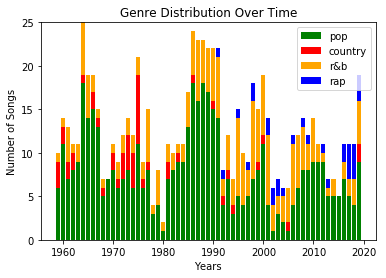

In [11]:
df = pd.DataFrame(all_years)
df = df.transpose()
x = df.index.values
c, p, b, r = df['country'], df['pop'], df['r&b'], df['rap']
plt.bar(x, p, label='pop', color = 'green')
plt.bar(x, c, label='country', color = 'red', bottom = p)
plt.bar(x, b, label='r&b', color = 'orange', bottom = p+c)
plt.bar(x, r, label='rap', color = 'blue', bottom = p+c+b)

plt.xlabel('Years')
plt.ylabel('Number of Songs')
plt.title('Genre Distribution Over Time')
plt.legend(loc='upper right')
plt.show()

As we can see, pop consistently seemed to be the most popular genre throughout the years. What is interesting is that country seemed very popular in older songs (in the 60’s and 70’s) before fading away and sporadically making an appearance in the charts.. We can also see the growing popularity of rap songs starting from the early 90’s as well as r&b which always stayed at the charts but grew more popular starting in the 80’s.



## Song Length Analysis 
Then, we decided to analyze any changes in the song length over years. We expected trends in this data as there were many advancement in music technology, and song length is somewhat related to the genre of the song. This data was also scraped from Wikipedia page like the genre of the song. 

In [12]:
def getLength(title, artist):
    search = wikipedia.search(title + " " + artist)
    if search != []:
        search = search[0]
    else:
        return
    try:
        url = wikipedia.page(search).url
        req_page = requests.get(url)
        data = BeautifulSoup(req_page.text, 'html.parser')
        duration = data.find('span', attrs={'class': 'duration'}).text.split(':')
        if (len(duration) == 2):
            time = int(duration[0])*60 + int(duration[1])
            return time
    except:
        return

In [13]:
years = [x for x in songs]
durs = []
for year in songs:
    total = 0
    count = 0
    for s in songs[year]:
        title = s[0].lower()
        artist = s[1].lower()
        if "and" in artist:
            index = artist.index("and")
            artist = artist[0:index-1]
        length = getLength(title, artist)
        if (length != None and length < 1000):
            count += 1
            total += length
    durs.append(total/count)

print('Done scraping song length')

Done scraping song length


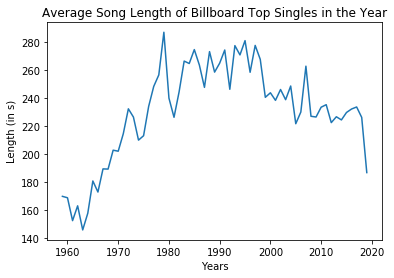

In [14]:
plt.plot(years, durs)
plt.xlabel('Years')
plt.ylabel('Length (in s)')
plt.title('Average Song Length of Billboard Top Singles in the Year')
plt.show()

The above plot shows the change of average song length over the years. The average song length continuously increased until early 1980s and was similar until mid 1990s. Since late 1990s and early 2000s, the song length has a decreasing trend and had a sharp drop in recent years. We expect that the increase in the earlier times was due to advance in music technology and popularity of dance or techno music that were packed with sounds and dance breaks. The drop in recent years may be explained by the trend of minimalism in pop songs where songs often don't have bridge parts or have very short or no intro, interludes, or outro. 

## Number of Unique Song 
Then, we analyzed the number of unique songs per year over the years. This is essentially the number of songs in the Billboard Top 100 Singles chart for the year. In order to proceed with this, we created a dictionary lyricsDict that maps years to another dictionary which maps a tuple of the title and artists to lyrics, as shown below.  

In [15]:
# LyricsDict is a dictionary that maps Year -> (Title, Singer) -> Lyrics

lyricsDict = dict()
for year in songs:
    lyricsDict[year] = dict()
    for song in songs[year]:
        try:
            lyrics = scrape(song[0].lower(), song[1].lower())
            text = re.sub("([\(\[]).*?([\)\]])", "", lyrics)
            text = re.sub(' +', ' ', text)
            text = re.sub('[\n][\n]+','\n', text)
            lyricsDict[year][song] = text
        except:
            continue
            
print('Done building lyricsDict')

Done building lyricsDict


In [16]:
sid = SentimentIntensityAnalyzer()

'''Given some text, returns polarity_scores.
This includes the compound value, which is broken down into pos, neg and neutral'''

def getPolarityScores(text):
    score = sid.polarity_scores(text)
    return score
    
'''A dictionary from Year -> a dictionary containing count, number of 'positive' lyrics,
'negative' lyrics and 'neutral' lyrics as classified from getPolarityScores'''
polarityCount = dict()
for year in lyricsDict:
    
    polarityCount[year] = dict()
    polarityCount[year]["count"] = len(lyricsDict[year])
    polarityCount[year]["pos"] = 0
    polarityCount[year]["neg"] = 0
    polarityCount[year]["neut"] = 0

    for song in lyricsDict[year]:
        lyrics = lyricsDict[year][song]
        score = getPolarityScores(lyrics)
            
        if(score['compound']>0):
            polarityCount[year]["pos"] += 1
        elif(score['compound'] < 0):
            polarityCount[year]['neg'] += 1
        else:
            polarityCount[year]['neut'] += 1


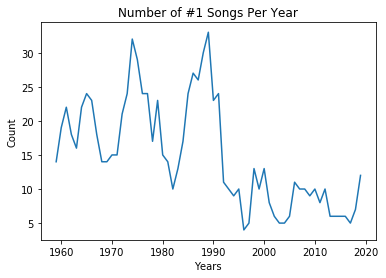

In [17]:
years = [year for year in polarityCount]
years.sort()
yTop100 = [polarityCount[year]['count'] for year in years]
plt.plot(years, yTop100)
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Number of #1 Songs Per Year')
plt.show()

Interestingly, we saw that the general trend of the number of songs on the top singles chart seems to be decreasing since 1990. This means that on average each song actually stays on the chart longer and that back in 1990 there were many songs that made it to the top singles chart, but they didn’t stay there for that long!


## Sentiment Analysis
Now we proceeded to do some sentiment analysis of these songs. NLTK offers some powerful packages which identifies the sentiment of a piece of text and return a number. Values less than 0 and greater than are considered to have negative and positive sentiment respectively. Values equal to 0 are considered neutral, but this is quite rare. 

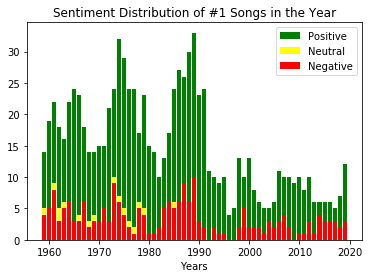

In [18]:
posCount = np.array([polarityCount[year]['pos'] for year in years])
negCount = np.array([polarityCount[year]['neg'] for year in years])
neutCount = np.array([polarityCount[year]['neut'] for year in years])

plt.bar(years, posCount, width=0.8, label='Positive', color='green', bottom=neutCount+negCount)
plt.bar(years, neutCount, width=0.8, label='Neutral', color='yellow', bottom=negCount)
plt.bar(years, negCount, width=0.8, label='Negative', color='red')

plt.xlabel("Years")
plt.legend(loc="upper right")
plt.title("Sentiment Distribution of #1 Songs in the Year")

plt.show()

The graph above provides a breakdown of the sentiments of each top single over the years, but it is not helpful in comparing the sentiment breakdown since the number of singles is not constant. So, we normalized the sentiment breakdown to be able to make comparisons:


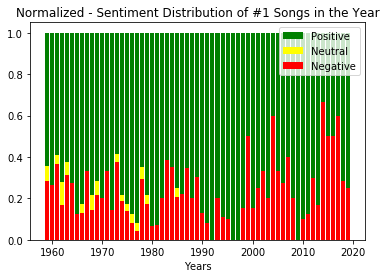

In [19]:
posCountNorm = np.array([polarityCount[year]['pos']/polarityCount[year]['count'] for year in years])
negCountNorm = np.array([polarityCount[year]['neg']/polarityCount[year]['count'] for year in years])
neutCountNorm = np.array([polarityCount[year]['neut']/polarityCount[year]['count'] for year in years])

plt.bar(years, posCountNorm, width=0.8, label='Positive', color='green', bottom=neutCountNorm+negCountNorm)
plt.bar(years, neutCountNorm, width=0.8, label='Neutral', color='yellow', bottom=negCountNorm)
plt.bar(years, negCountNorm, width=0.8, label='Negative', color='red')

plt.xlabel("Years")
plt.legend(loc="upper right")
plt.title("Normalized - Sentiment Distribution of #1 Songs in the Year")

plt.show()

Overall, it seems that the majority of the top singles are considered to have a positive sentiment. Interestingly, there does seem to be a gradual increase in the number of songs with negative sentiment over the years. 


# Analysis Based on Gender
We then broke down the data into females and males to do some further analysis to see if we notice anything interesting. In order to do so, we labeled the data with a gender column. To do this, we collected a list of the artists since 1959 (which is about 530 different artists) and printed this into a CSV file. 

In [20]:
#Produces a csv file of all the artists

artist = []
for year in lyricsDict:
    songs = lyricsDict[year]
    for songs in lyricsDict[year]:
        artist += [songs[1]]

zippedList =  list(set(artist))

df = pd.DataFrame(zippedList, columns = ['Artist']) 
df.to_csv("artists.csv")

We manually labeled the data set and then read this new CSV file and include this in our dataset. This image shows how the labeled CSV file looks. Note that we skipped groups with both male and female band members.

<img src="CSVFile.png" alt="Drawing" style="width: 200px;"/>

In [21]:
# Reads in labeled CSV file and saves as dataframe
reader = csv.reader(open('artists-filled.csv', 'r'))
artistGender = {}
first = True

for row in reader:
    if(first):
        first = False
        continue
    _, k, v = row
    if(v == 'F'):
        value = True
    elif(v == 'M'):
        value = False
    else:
         continue
    artistGender[k] = value

In [22]:
'''
femaleLyrics is now subset of lyricsDict, but only for female artists and groups. 
maleLyrics is just like femaleLyrics, but for male artists and groups.
'''

femaleLyrics = dict()
for key in lyricsDict:
    femaleLyrics[key] = dict()
    for song in lyricsDict[key]:
        art = song[1]
        if(art in artistGender and artistGender[art]):
            femaleLyrics[key][song] = lyricsDict[key][song]


maleLyrics = dict()
for key in lyricsDict:
    maleLyrics[key] = dict()
    for song in lyricsDict[key]:
        art = song[1]
        if(art in artistGender and not artistGender[art]):
            maleLyrics[key][song] = lyricsDict[key][song]

## Number of Female Artists

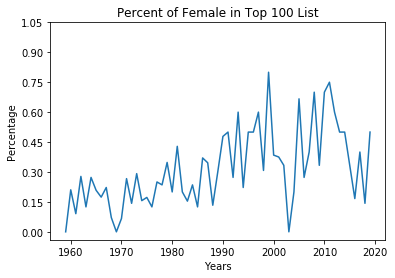

In [23]:
femaleTop100Count = [len(femaleLyrics[year])/polarityCount[year]['count'] for year in femaleLyrics]
xVals = [year for year in femaleLyrics]

plt.plot(xVals, femaleTop100Count)
plt.xlabel('Years')
plt.ylabel('Percentage')
plt.title('Percent of Female in Top 100 List')
plt.yticks(np.arange(0, 1.1, step=0.15))
plt.show()

With this new data of gender, we were able to isolate the female artists who made it on the Billboard Top Singles chart and plotted the percent of females on the chart per year over the years, and noticed the overall increasing trend! There was an interesting outlier year which also shows up irregularly in the following data, which was 2004. Referencing back to the Wiki page, this happened to be a year where there was only 1 female artist who had a Billboard Hot 100 top single, but their song wasn’t able to be properly scraped from the Genius API. As a result, there are no recorded females for that year in the dataset. 


## Sentiment Analysis
Now we did the same sentiment analysis as we did above (including the normalizing step), but only for females and males separately.


In [24]:
#Just like polarityCount, but for females only.

fempolarityCount = dict()
for year in femaleLyrics:
    
    fempolarityCount[year] = dict()
    fempolarityCount[year]["count"] = len(femaleLyrics[year])
    fempolarityCount[year]["pos"] = 0
    fempolarityCount[year]["neg"] = 0
    fempolarityCount[year]["neut"] = 0

    for song in femaleLyrics[year]:
        lyrics = femaleLyrics[year][song]
        score = getPolarityScores(lyrics)
            
        if(score['compound']>0):
            fempolarityCount[year]["pos"] += 1
        elif(score['compound'] < 0):
            fempolarityCount[year]['neg'] += 1
        else:
            fempolarityCount[year]['neut'] += 1
        

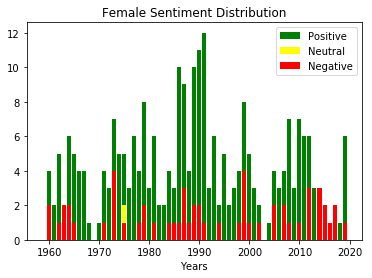

In [25]:
fposCount = np.array([fempolarityCount[year]['pos'] for year in femaleLyrics])
fnegCount = np.array([fempolarityCount[year]['neg'] for year in femaleLyrics])
fneutCount = np.array([fempolarityCount[year]['neut'] for year in femaleLyrics])

fyears = [years for years in femaleLyrics]
plt.bar(fyears, fposCount, width=0.8, label='Positive', color='green', bottom=fneutCount+fnegCount)
plt.bar(fyears, fneutCount, width=0.8, label='Neutral', color='yellow', bottom=fnegCount)
plt.bar(fyears, fnegCount, width=0.8, label='Negative', color='red')

plt.xlabel("Years")
plt.legend(loc="upper right")
plt.title("Female Sentiment Distribution")

plt.show()

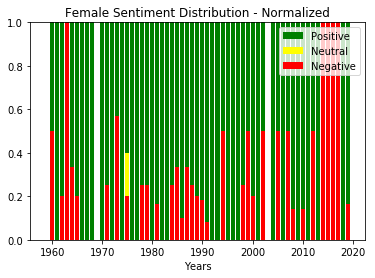

In [26]:
fposCountNorm = []
fnegCountNorm = []
fneutCountNorm = []
for year in femaleLyrics:
    if (fempolarityCount[year]['count'] == 0):
        fposCountNorm += [0]
        fnegCountNorm += [0]
        fneutCountNorm += [0]
    else:
        fposCountNorm += [fempolarityCount[year]['pos']/fempolarityCount[year]['count']]
        fnegCountNorm += [fempolarityCount[year]['neg']/fempolarityCount[year]['count']]
        fneutCountNorm += [fempolarityCount[year]['neut']/fempolarityCount[year]['count']]
fposCountNorm = np.array(fposCountNorm)
fnegCountNorm = np.array(fnegCountNorm)
fneutCountNorm = np.array(fneutCountNorm)

plt.bar(fyears, fposCountNorm, width=0.8, label='Positive', color='green', bottom=fneutCountNorm+fnegCountNorm)
plt.bar(fyears, fneutCountNorm, width=0.8, label='Neutral', color='yellow', bottom=fnegCountNorm)
plt.bar(fyears, fnegCountNorm, width=0.8, label='Negative', color='red')

plt.xlabel("Years")
plt.legend(loc="upper right")
plt.title("Female Sentiment Distribution - Normalized")

plt.show()

In [27]:
#Same thing but for males
malepolarityCount = dict()
for year in maleLyrics:
    
    malepolarityCount[year] = dict()
    malepolarityCount[year]["count"] = len(maleLyrics[year])
    malepolarityCount[year]["pos"] = 0
    malepolarityCount[year]["neg"] = 0
    malepolarityCount[year]["neut"] = 0

    for song in maleLyrics[year]:
        lyrics = maleLyrics[year][song]
        score = getPolarityScores(lyrics)
            
        if(score['compound']>0):
            malepolarityCount[year]["pos"] += 1
        elif(score['compound'] < 0):
            malepolarityCount[year]['neg'] += 1
        else:
            malepolarityCount[year]['neut'] += 1

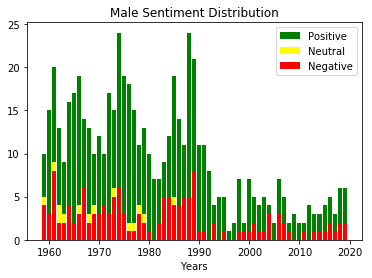

In [28]:
mposCount = np.array([malepolarityCount[year]['pos'] for year in maleLyrics])
mnegCount = np.array([malepolarityCount[year]['neg'] for year in maleLyrics])
mneutCount = np.array([malepolarityCount[year]['neut'] for year in maleLyrics])

myears = [years for years in maleLyrics]
plt.bar(myears, mposCount, width=0.8, label='Positive', color='green', bottom=mneutCount+mnegCount)
plt.bar(myears, mneutCount, width=0.8, label='Neutral', color='yellow', bottom=mnegCount)
plt.bar(myears, mnegCount, width=0.8, label='Negative', color='red')

plt.xlabel("Years")
plt.legend(loc="upper right")
plt.title("Male Sentiment Distribution")

plt.show()

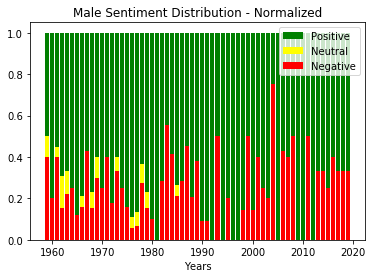

In [29]:
mposCountNorm = np.array([malepolarityCount[year]['pos']/malepolarityCount[year]['count'] for year in maleLyrics])
mnegCountNorm = np.array([malepolarityCount[year]['neg']/malepolarityCount[year]['count'] for year in maleLyrics])
mneutCountNorm = np.array([malepolarityCount[year]['neut']/malepolarityCount[year]['count'] for year in maleLyrics])

plt.bar(myears, mposCountNorm, width=0.8, label='Positive', color='green', bottom=mneutCountNorm+mnegCountNorm)
plt.bar(myears, mneutCountNorm, width=0.8, label='Neutral', color='yellow', bottom=mnegCountNorm)
plt.bar(myears, mnegCountNorm, width=0.8, label='Negative', color='red')

plt.xlabel("Years")
plt.legend(loc="upper right")
plt.title("Male Sentiment Distribution - Normalized")

plt.show()

Once again normalising the data provides more insight. When looking at the sentiment distribution for males, we see that it is on average the males top singles in a year are roughly half positive sentiment and half negative sentiment. It looks well distributed between the two. However, looking at the female sentiment, we see that in recent years, there has been a spike in negative sentiment songs. This is especially apparent between 2011 to 2018 where all the songs were categorised as having a negative sentiment. This is definitely interesting. 

## Word Cloud
Another aspect we can analyse due to having the gender label is most common words in songs of female vs males artists and can do so in the form of a word cloud. When doing this it is important to once again take into consideration the difference in the amount of data we have for males versus females. We have 582 songs for males, but only have 257 songs for females. Therefore, when constructing the word cloud, it is important to ‘normalize’ the count by dividing the count by the size of the respective data set. We expect there to be a lot of similar words for the word clouds. For example, ‘Love’ is likely to be a very common word for both males and females. While this is meaningful, it isn’t really helpful when trying to compare the two word clouds. For females, we want to identify what words are either more common for females artists to sing than their male counterparts or words that females sings that males don’t. Under this format of analysis, the following word clouds are produced:

In [41]:
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def lemmatizer(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))
    
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # Converting to Lowercase
    text = text.lower()
    
    # Lemmatization
    text = text.split()

    text = [stemmer.lemmatize(word) for word in text]
    text = ' '.join(text)
    
    return text

Females:


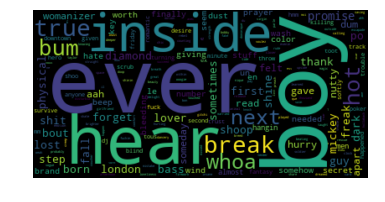

Males:


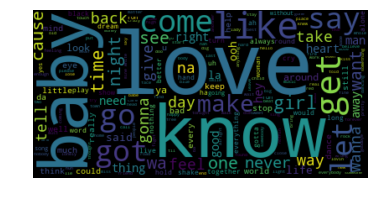

In [42]:
import collections
femaleCnt = collections.Counter()

stopSet = set(nltk.corpus.stopwords.words('english') + ['yeah','oh'])

for year in femaleLyrics:
    for (title,artist) in femaleLyrics[year]:
        lyr = femaleLyrics[year][(title,artist)]
        lyr = lemmatizer(lyr).split()
        for word in lyr:
            if(word not in stopSet):
                femaleCnt[word] += 1

maleCnt = collections.Counter()

for year in maleLyrics:
    for (title,artist) in maleLyrics[year]:
        lyr = maleLyrics[year][(title,artist)]
        lyr = lemmatizer(lyr).split()
        for word in lyr:
            if(word not in stopSet):
                maleCnt[word] += 1

femaleCntDict = dict(femaleCnt)
maleCntDict = dict(maleCnt)

femaleNew = {key:femaleCntDict[key] for key in femaleCntDict if key not in maleCntDict
            or femaleCntDict[key] > maleCntDict[key]}
maleNew = {key:maleCntDict[key] for key in maleCntDict if key not in femaleCntDict
          or femaleCntDict[key] < maleCntDict[key]}

from wordcloud import WordCloud

wordcloud = WordCloud()
print('Females:')
wordcloud.generate_from_frequencies(frequencies=femaleNew)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print('Males:')
wordcloud.generate_from_frequencies(frequencies=maleNew)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Predicting Gender
Now with all the data, we built a model that predicts the gender of the artist who sang that song given the lyrics as input. As our X and y inputs, we have a list of lyrics (which will be lemmatized) and a list of 1s and 0s (where 1s represents female and 0 represents male) respectively. The model below was built after referencing citation 1 below. We vectorized our input from text to integers with the bag of words model and then further transform into TFIDF feature values. With these prepared data inputs, we used the Random Forest algorithm to train the model.

In [43]:
artist = []
title = []
lyrics = []
gender = []
y = []
for year in lyricsDict:
    songs = lyricsDict[year]
    for songs in lyricsDict[year]:
        if(songs[1] not in artistGender): #Skip this artist
            continue
        title += [songs[0]]
        artist += [songs[1]]
        lyrics += [lyricsDict[year][songs]]
        gender += [artistGender[songs[1]]]
        if(artistGender[songs[1]]):
            y += [1]
        else:
            y += [0]

X = lyrics

In [44]:
documents = []

for sen in range(0, len(X)):
    document = lemmatizer(X[sen])
    documents.append(document)
    continue
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)

In [45]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/minjilee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [48]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [49]:
y_pred = classifier.predict(X_test)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[106   4]
 [ 48  10]]
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       110
           1       0.71      0.17      0.28        58

   micro avg       0.69      0.69      0.69       168
   macro avg       0.70      0.57      0.54       168
weighted avg       0.70      0.69      0.62       168

0.6904761904761905


We see that the data we built has an accuracy score of nearly 70%. 

# Summary and Future Work
In this project, we began by scraping the Billboard Hot 100 Top Singles and its corresponding lyrics since 1959 from Wikipedia and Genius.com and performed some preliminary data analysis on it. Doing so, we found out that country is sporadically making an appearance back in the charts, rap music is getting increased presence, song lengths are getting shorter recently, and there seems to be a gradual increase in the number of songs with negative sentiment over the years. We then broke down the data to include the gender of the artist and did this by manually labeling the data. Doing so enabled us to do sentiment analysis separately on either gender and saw that there has actually been a rise in the negative sentiment songs for females recently. Lastly, we used this data to build a model for predicting the gender of an artist from the lyrics alone. Some possible further investigation could include trying to identify a model that predict the gender more accurately. As above, we decided to use a Random Forest algorithm which gave us an accuracy of 70%. This was still better than the SVM model for text classification we used in a previous homework assignment, which gave us a 60% for the same data. Another interesting area to explore would be to analyze the rhythm and tempo of a song and use this into account when deciding the sentiment for a particular song.

**Further Works**:
While lyrics is an integral portion of a song, lyric itself doesn't say too much about the sentiment. For instance, the same sentence "I love you" may have very different nuance based on the way it is said. In songs, rhythm and melody can add context to the lyrics. While there are many research based on the audio, it will be interesting to further investigate how lyrics and audio of the song relate to each other to tell a complete story. 


# References
[1] https://stackabuse.com/text-classification-with-python-and-scikit-learn/ 

[2] http://www.nltk.org/howto/sentiment.html

[3] https://medium.com/analytics-vidhya/web-scraping-wiki-tables-using-beautifulsoup-and-python-6b9ea26d8722

[4] https://dev.to/willamesoares/how-to-integrate-spotify-and-genius-api-to-easily-crawl-song-lyrics-with-python-4o62